In [1]:
!pip install simpletransformers

import pandas as pd
import numpy as np

from nltk import word_tokenize, download
from nltk.corpus import stopwords

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Layer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import models

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from simpletransformers.classification import ClassificationModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import statistics as st

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dir = '/content/gdrive/My Drive/Colab Notebooks/cs4248/Project/'

In [4]:
def load_data(train_file, test_file, column_name):
    train_df = pd.read_csv(train_file, names=column_name)
    test_df = pd.read_csv(test_file, names=column_name)
    return train_df, test_df

In [5]:
download('stopwords')
nltk_stopwords = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def tokenize(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in nltk_stopwords]

    return " ".join(tokens)


def preprocess_data(train_df, test_df):
    import time
    start = time.time()
    minute = 0

    for df in [train_df, test_df]:
        for i in range(df.shape[0]):
            if time.time() - start >= minute * 60:
                print(str(minute) + " minutes: " + str(i) + " iterations done.")
                minute += 1
            df.at[i, "text"] = tokenize(df.at[i, "text"])

    return train_df, test_df

In [7]:
# For RNN
download('vader_lexicon')
senti_analyzier = SentimentIntensityAnalyzer()
def get_senti(sentence):
    score = senti_analyzier.polarity_scores(sentence)['compound']

    if score > 0.05:
        return 1
    if score < -0.05:
        return -1
    return 0

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
def get_train_test_data(x_train, y_train, x_test, y_test, mode, maxlen, n_unique_words):
    # tokenize the data
    tokenizer = Tokenizer(num_words=n_unique_words)
    tokenizer.fit_on_texts(x_train)
    sequences = tokenizer.texts_to_sequences(x_train)
    x_train = pad_sequences(sequences, maxlen=maxlen)
    y_train = to_categorical(y_train - 1, num_classes=4)

    if mode == 'valid':
        return train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    sequences = tokenizer.texts_to_sequences(x_test)
    x_test = pad_sequences(sequences, maxlen=maxlen)
    y_test = to_categorical(y_test - 1, num_classes=4)
    return x_train, x_test, y_train, y_test

In [9]:
# Config
mode = 'test'
maxlen = 200
n_unique_words = 20000

In [10]:
train_path = dir + "fulltrain.csv"
test_path = dir + "balancedtest.csv"

xlnet_path = dir + "xlnet"
rnn_path = dir + "rnn"
lstm_path = dir + "lstm"

In [11]:
train_df, test_df = load_data(train_path, test_path, ["label", "text"])

In [12]:
train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [13]:
test_df.head()

,label,text
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [14]:
x_train, y_train = train_df["text"].values, train_df["label"].values
x_test, y_test = test_df["text"].values, test_df["label"].values

In [15]:
X_train, X_test, y_train, y_test = get_train_test_data(x_train, y_train, x_test, y_test, mode, maxlen, n_unique_words)

In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
xlnet = ClassificationModel('xlnet', xlnet_path, num_labels=4, args={"overwrite_output_dir": True, "num_train_epochs":4, "do_lower_case":True}, use_cuda=False)

In [18]:
rnn = models.load_model(rnn_path)

In [19]:
lstm = models.load_model(lstm_path)

In [20]:
pred_xlnet = xlnet.predict(list(x_test))

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

In [21]:
xlnet_label, raw_outputs = pred_xlnet

In [22]:
sentiments = np.array([get_senti(text) for text in x_test])
rnn_pred = rnn.predict([x_test, sentiments])

94/94 [==============================] - 4s 29ms/step


In [23]:
lstm_pred = lstm.predict(X_test)

94/94 [==============================] - 13s 129ms/step


In [24]:
test_label = np.argmax(y_test, axis=1)

In [25]:
## XLNET
print(classification_report(test_label, xlnet_label))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       750
           1       0.97      0.90      0.94       750
           2       0.63      0.10      0.18       750
           3       0.51      0.99      0.68       750

    accuracy                           0.71      3000
   macro avg       0.75      0.71      0.66      3000
weighted avg       0.75      0.71      0.66      3000



In [26]:
## RNN
rnn_label = np.argmax(rnn_pred, axis=1)
print(classification_report(test_label, rnn_label))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       750
           1       0.78      0.34      0.47       750
           2       0.58      0.81      0.68       750
           3       0.74      0.88      0.80       750

    accuracy                           0.70      3000
   macro avg       0.72      0.70      0.68      3000
weighted avg       0.72      0.70      0.68      3000



In [32]:
## RNN
lstm_label = np.argmax(lstm_pred, axis=1)
print(classification_report(test_label, lstm_label))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       750
           1       0.63      0.31      0.42       750
           2       0.52      0.74      0.61       750
           3       0.73      0.90      0.81       750

    accuracy                           0.65      3000
   macro avg       0.66      0.65      0.64      3000
weighted avg       0.66      0.65      0.64      3000



In [27]:
from sklearn.metrics import multilabel_confusion_matrix

In [28]:
labels = ["Satire", "Hoax", "Propaganda", "Reliable News"]

def cm_display(cm):
  for i in range(4):
    label = labels[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp.plot()
    plt.title(label)
  
  plt.show()

In [29]:
from scipy import stats

Voting

In [33]:
votes = []
for i in range(len(test_label)):
  votes.append(stats.mode([xlnet_label[i], rnn_label[i], lstm_label[i]], keepdims=False)[0])
votes = np.array(votes)

In [34]:
print(classification_report(test_label, votes))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       750
           1       0.88      0.52      0.65       750
           2       0.63      0.67      0.65       750
           3       0.76      0.96      0.85       750

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.74      3000
weighted avg       0.76      0.75      0.74      3000



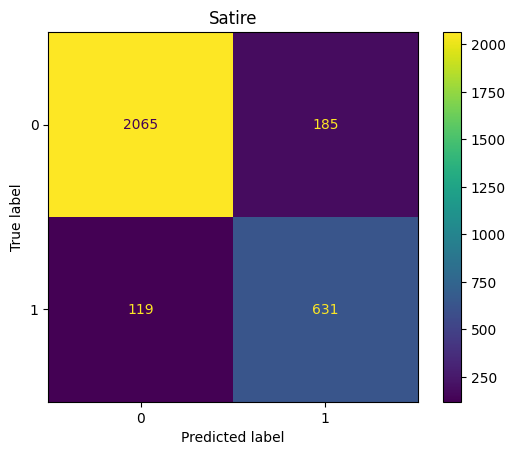

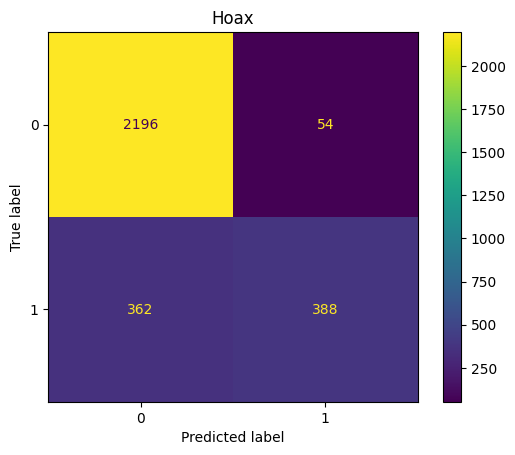

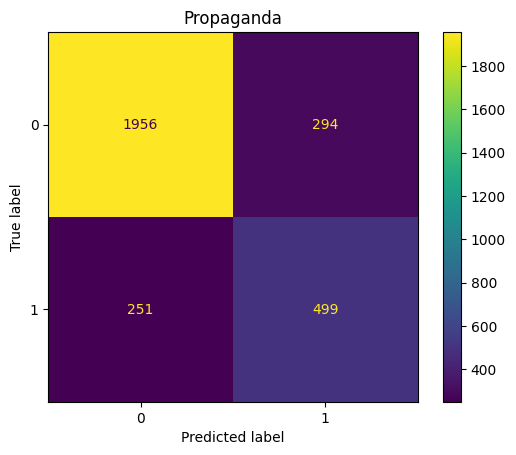

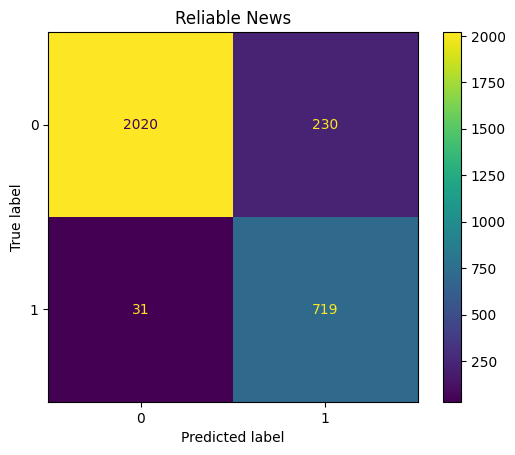

In [35]:
cm_display(multilabel_confusion_matrix(test_label, votes))

In [36]:
from scipy.special import softmax
xlnet_prob = softmax(raw_outputs, axis=1)

In [37]:
combined_prob = np.sum([xlnet_prob, rnn_pred, lstm_pred] , axis=0) / 3
combined_prob = np.argmax(combined_prob, axis=1)

In [38]:
print(classification_report(test_label, combined_prob))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       750
           1       0.90      0.59      0.71       750
           2       0.65      0.69      0.67       750
           3       0.72      0.97      0.82       750

    accuracy                           0.77      3000
   macro avg       0.79      0.77      0.77      3000
weighted avg       0.79      0.77      0.77      3000



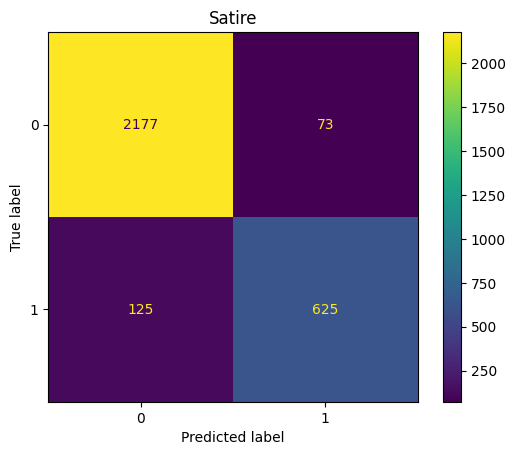

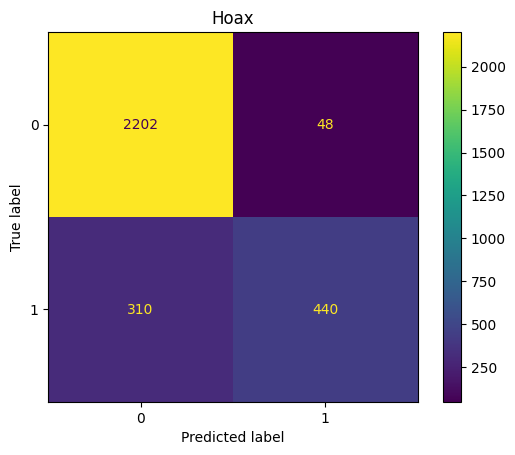

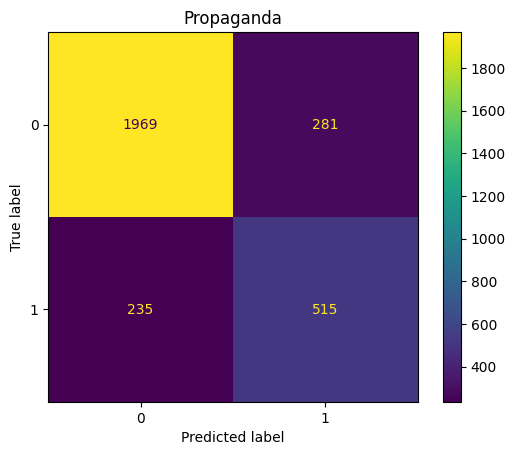

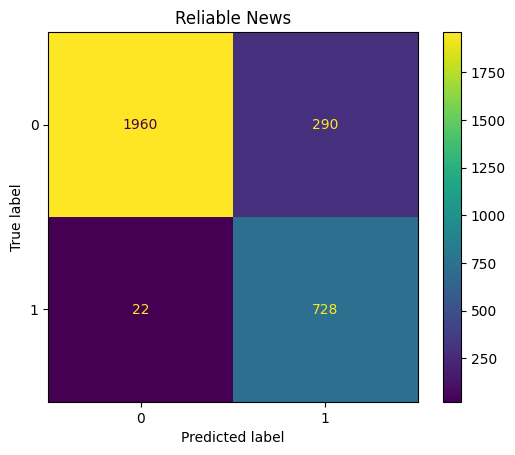

In [39]:
cm_display(multilabel_confusion_matrix(test_label, combined_prob))

In [40]:
data = {"predicted": np.array(xlnet_label), "actual": test_label}
xlnet_df = pd.DataFrame(data)
xlnet_df.to_csv(dir + "xlnet_prediction.csv", index=False)

In [41]:
data = {"predicted": np.array(rnn_label), "actual": test_label}
rnn_df = pd.DataFrame(data)
rnn_df.to_csv(dir + "rnn_prediction.csv", index=False)

In [42]:
data = {"predicted": np.array(lstm_label), "actual": test_label}
lstm_df = pd.DataFrame(data)
lstm_df.to_csv(dir + "lstm_prediction.csv", index=False)

In [43]:
data = {"predicted": np.array(votes), "actual": test_label}
votes_df = pd.DataFrame(data)
votes_df.to_csv(dir + "votes_prediction.csv", index=False)

In [44]:
data = {"predicted": np.array(combined_prob), "actual": test_label}
prob_df = pd.DataFrame(data)
prob_df.to_csv(dir + "aggregation.csv", index=False)